# Question Answering on SQuAD dataset
Made by Marco Aspromonte, Valentina Boriano, Enrico Morselli and Francesco Romito

We decided to keep into the following notebook only the most significant model ,
but it is possible to test all the other flavours modifing little highlighted part of the code.

In [1]:
!jupyter nbextension enable --py widgetsnbextension
from IPython.display import clear_output
clear_output()

In [2]:
import transformers
import random
import json
from tqdm.auto import tqdm
from datasets import load_dataset, load_metric, ClassLabel, Sequence
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML
from transformers import AutoTokenizer
from transformers import TFAutoModelForQuestionAnswering
from transformers import DefaultDataCollator
from transformers import create_optimizer
import collections
import evaluation_custom as ev
# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import collections
from collections import OrderedDict
import evaluation_custom as ev
# normalizing answers
import string
import re

LOADING THE DATASET

Our main dataset is the SQuAD dataset which is contained in training_set.json

We decided to divide the training_set.json into:

1.   training set which contains 75% of the dataset
2.   validation set which contains 25% of the dataset

Now we let the choice to the user:

- If he wants to use the  validation set also as the test set, set duorc = False

- If he wants to use the duorc dataset as the test set, set duorc = True

Moreover we can choose which model to use by setting var to:

0. in order to use the distilbert model
1. in order to use the distilroberta model
2. in order to use the albert model v2 by huggingface

In [3]:
duorc = False # Set to false if you want to test only on SQuAD
train = False # Set to False if you donnot want to train the model
ind = 2 # Change the index from 0 to 2 to test different transformers
model_checkpoint_list = ["distilbert-base-uncased", "distilroberta-base", 'albert-base-v2']
model_checkpoint = model_checkpoint_list[ind] # Bert checkpoint, there are some others that we can try

In [4]:
input_filename = "training_set.json"

# From the input set we split into training and validation
train_filename = "train_set.json"
val_filename = "val_set.json"

if duorc == True:
  test_filename = "duorc.json"
else:
  test_filename = val_filename

with open(input_filename) as f:
    dataset_base = json.load(f)

train_split = int(len(dataset_base['data'])*0.75)
train_articles = dataset_base['data'][0:train_split] 
val_articles = dataset_base['data'][train_split::]

We created the method *import_dataset* to generate a new json file with only the columns:

1.   Title
2.   Id
3.   Context
4.   Question
5.   Answer

starting from the original json file

In [5]:
def import_dataset(split_filename, split_articles):
  with open(split_filename, "w") as f:
      for article in split_articles:
          title = article["title"]
          for paragraph in article["paragraphs"]:
              context = paragraph["context"]
              answers = {}
              for qa in paragraph["qas"]:
                  question = qa["question"]
                  idx = qa["id"]
                  answers["text"] = [a["text"] for a in qa["answers"]]
                  answers["answer_start"] = [a["answer_start"] for a in qa["answers"]]
                  f.write(
                      json.dumps(
                          {
                              "id": idx,
                              "title": title,
                              "context": context,
                              "question": question,
                              "answers": answers,
                          }
                      )
                  )
                  f.write("\n")

Here, if the flag is set to true, we import the Duorc dataset to be used as test set.

As a remind, we have done this in order to test how the model is capable to deal with questions from another dataset

In [6]:
if duorc == True:
    dataset_duorc = load_dataset('duorc','SelfRC',split='test')
    df_duorc = dataset_duorc.to_pandas()
    df_duorc.head()
    df_duorc.pop('plot_id')
    df_duorc = df_duorc.drop(df_duorc[df_duorc.no_answer == True].index)
    df_duorc.pop('no_answer')
    start_char = []
    to_remove = []
    for i in df_duorc.index:
        try:
            start_char.append(df_duorc['plot'][i].index(df_duorc['answers'][i][0]))
        except:
            to_remove.append(i)
    df_duorc = df_duorc.drop(index=to_remove)
    df_duorc = df_duorc.reset_index()
    df_duorc.pop('index')
    answ = []
    for i in df_duorc.index:
        answ.append(df_duorc.answers[i][0])
    keylist = ['answer_start', 'text']
    values_list = (start_char, answ)
    newl = []
    d = {}
    for i in range(len(answ)):
        d['answer_start'] = [start_char[i]]
        d['text'] = [answ[i]]
        newl.append(d)
        d = {}
    df_duorc['answers'] = newl
    df_duorc = df_duorc.rename({'plot': 'context', 'question_id': 'id'}, axis=1)  # new method
    with open("duorc.json", 'a') as f:
        f.truncate(0)
        for i in range(0, df_duorc.shape[0]):
            f.write(
                json.dumps(
                    {
                        "id": df_duorc.id[i],
                        "title": df_duorc.title[i],
                        "context": df_duorc.context[i],
                        "question": df_duorc.question[i],
                        "answers": df_duorc.answers[i],
                    }
                )
            )
            f.write("\n")

In [7]:
import_dataset(train_filename, train_articles) #Generating the train json
import_dataset(val_filename, val_articles)  #Generating the validation json
dataset = load_dataset('json', data_files={'train':train_filename, 'validation': val_filename, 'test': test_filename})

if duorc==True:

    #The lines above are needed to perform the valuation of the results
    
    ground_truth = []
    ids = dataset['test']['id']
    answ = dataset['test']['answers']
    for i in range(0,dataset['test'].shape[0]):
        ground_truth.append([ids[i], answ[i]['text'][0]])
    with open('ground_truth.json', 'w') as json_file:
        json.dump(ground_truth, json_file)
        
    ground_tr_dict = {}
    ground_tr_dict['data'] = df_duorc

else:
    
    #The lines above are needed to perform the valuation of the results

    ground_tr_dict = {}
    ground_tr_dict['data'] = dataset_base['data'][train_split:]
    ground_tr_dict['version'] = dataset_base['version'][train_split:]
    with open('ground_truth.json', 'w') as json_file:
        json.dump(ground_tr_dict, json_file)




Using custom data configuration default-031cab19e5a86be9


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to C:\Users\franc\.cache\huggingface\datasets\json\default-031cab19e5a86be9\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
#showing our dataset
dataset['train'][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

Now we show the distributions of the lengths of answer, text and question (of training and test set) in order to study the dataframe and the respective results. 

First of all we created two methods to define the length in words and then we plot all the graphics

In [9]:
def len_answer(dataset,type):
  len_answers = []
  for i in range(0,len(dataset[type])):
    for j in range(0,len(dataset[type][i]['answers']['text'])):
      len_answers.append(len(dataset[type][i]['answers']['text'][j].split()))
  return len_answers

In [10]:
def len_maker(dataset,type,feature):
  len_ = []
  for i in range(0,len(dataset[type])):
      len_.append(len(dataset[type][i][feature].split()))
  return len_

In [11]:
len_answers = len_answer(dataset,"train")
keys, counts = np.unique(len_answers, return_counts=True)

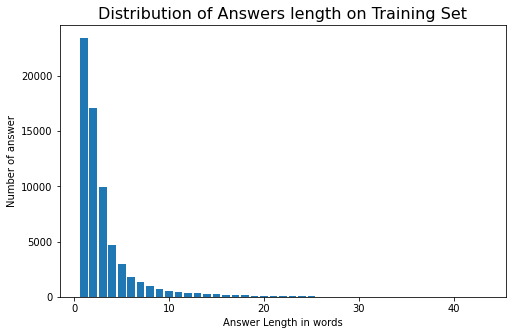

In [12]:
plt.figure(figsize=(8,5)) 
plt.bar(keys, counts) 
plt.title('Distribution of Answers length on Training Set', fontsize=16) 
plt.ylabel('Number of answer') 
plt.xlabel('Answer Length in words')
plt.show()

In [13]:
len_answers_val = len_answer(dataset,"test")
keys, counts = np.unique(len_answers_val, return_counts=True)

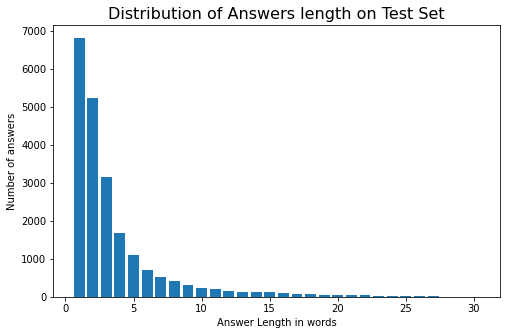

In [14]:
plt.figure(figsize=(8,5)) 
plt.bar(keys, counts) 
plt.title('Distribution of Answers length on Test Set', fontsize=16) 
plt.ylabel('Number of answers') 
plt.xlabel('Answer Length in words')
plt.show()

In [15]:
len_context= len_maker(dataset,"train", "context")
keys, counts = np.unique(len_context, return_counts=True)

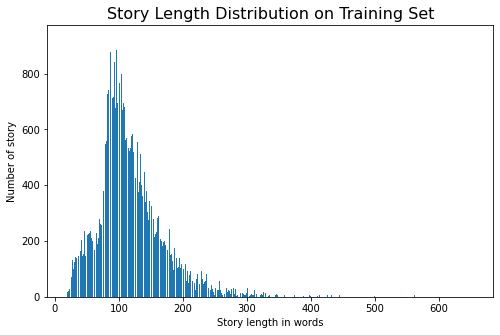

In [16]:
plt.figure(figsize=(8,5)) 
plt.bar(keys, counts) 
plt.title('Story Length Distribution on Training Set', fontsize=16) 
plt.ylabel('Number of story') 
plt.xlabel('Story length in words')
plt.show()

In [17]:
len_context_val= len_maker(dataset,"test", "context")
keys, counts = np.unique(len_context_val, return_counts=True)

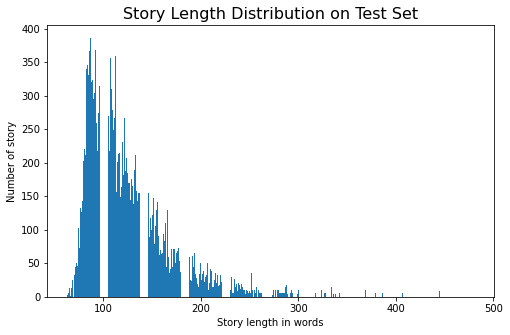

In [18]:
plt.figure(figsize=(8,5)) 
plt.bar(keys, counts) 
plt.title('Story Length Distribution on Test Set', fontsize=16) 
plt.ylabel('Number of story') 
plt.xlabel('Story length in words')
plt.show()

In [19]:
len_question = len_maker(dataset,"train", "question")
keys, counts = np.unique(len_question, return_counts=True)

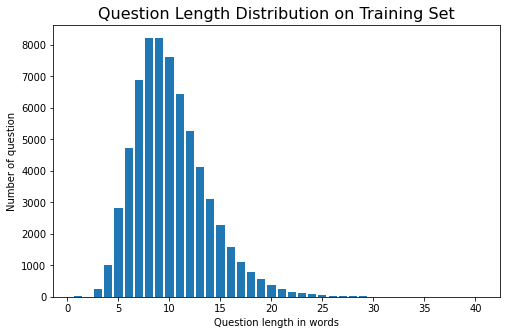

In [20]:
plt.figure(figsize=(8,5)) 
plt.bar(keys, counts) 
plt.title('Question Length Distribution on Training Set', fontsize=16) 
plt.ylabel('Number of question') 
plt.xlabel('Question length in words')
plt.show()

In [21]:
len_question_val = len_maker(dataset,"validation", "question")
keys, counts = np.unique(len_question_val, return_counts=True)

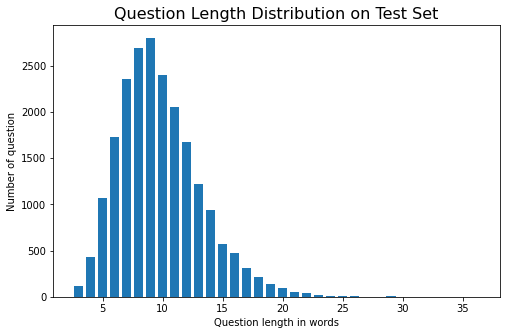

In [22]:
plt.figure(figsize=(8,5)) 
plt.bar(keys, counts) 
plt.title('Question Length Distribution on Test Set', fontsize=16) 
plt.ylabel('Number of question') 
plt.xlabel('Question length in words')
plt.show()

Text(0.5, 0, 'Question type')

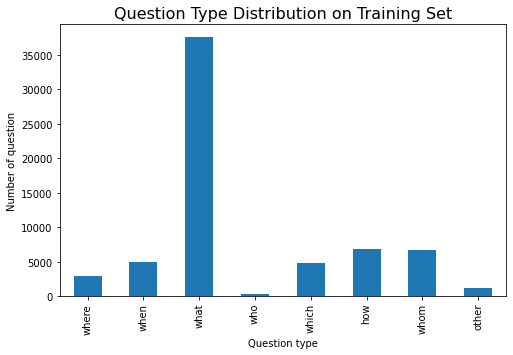

In [23]:
question_type = ev.search_type_question(dataset,"train") 
plt.figure(figsize=(8,5))  
plotdata = pd.DataFrame( 
    {"question": question_type},  
    index=["where","when","what","who","which","how","whom","other"]) 
plotdata['question'].plot(kind="bar", title="test") 
plt.title('Question Type Distribution on Training Set', fontsize=16)  
plt.ylabel('Number of question')  
plt.xlabel('Question type')

Text(0.5, 0, 'Question type')

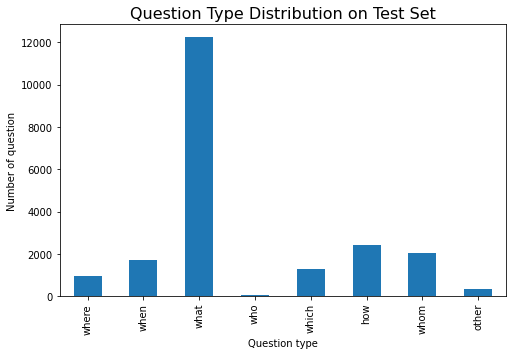

In [24]:
question_type = ev.search_type_question(dataset,"test") 
plt.figure(figsize=(8,5))  
plotdata = pd.DataFrame( 
    {"question": question_type},  
    index=["where","when","what","who","which","how","whom","other"]) 
plotdata['question'].plot(kind="bar", title="test") 
plt.title('Question Type Distribution on Test Set', fontsize=16)  
plt.ylabel('Number of question')  
plt.xlabel('Question type')

Some parameters for the network setting. 

In [25]:
batch_size = 2 # suggested by the official paper at 16-32, but due to technical limitation we are forced to set it at 2 and still works well
learning_rate = 2e-5 # other admissible by suggestion are 5e-5 and 3e-5
num_train_epochs = 3  #Usually for all the 3 models the best number of epochs before starting overfitting
weight_decay = 0.01
max_length = 384  # The maximum length of a feature (question and context) 
doc_stride = 128  # The authorized overlap between two part of the context when splitting it is needed.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

##Tokenization

Before of using BERT's Transformer we had to tokenized our input and we do it with 

In [26]:
def tokenize_dataset(dataset):
    #Since the roberta-like tokenizer have problems to deal with long sequences of spaces before and after the
    #text, it is needed some more data cleaning
    if model_checkpoint == "roberta-base" or "distilroberta-base":
        dataset["question"] = [q.lstrip() for q in dataset["question"]]    
    # Tokenize our questions with truncation and padding, but keep the overflows using a stride. This results
    # in one question possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.

    tokenized_dataset = tokenizer(  dataset["question"], dataset["context"],
                                    truncation="only_second",
                                    max_length=max_length,
                                    stride=doc_stride,
                                    return_overflowing_tokens=True,
                                    return_offsets_mapping=True,
                                    padding="max_length",
    )


    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding question. This key gives us just that.

    overflowing_tokens = tokenized_dataset.pop("overflow_to_sample_mapping") #with pop we remove the selected column from the dataset and we store it in sample mapping, 
                                                                         #basically this is a vector with enumerations from 0 to the lenght of the vector
                                                                         #created by return_overflowing_tokens in the tokenizer object

    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.

    offset_mapping = tokenized_dataset.pop("offset_mapping") # created by return_offsets_mapping in the tokenizer object


    # Now we have to label the questions
    
    tokenized_dataset["start_positions"] , tokenized_dataset["end_positions"] = list(),list()
     

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers (the answer is in another feature given by an example with a long context), with the index of the CLS token.
        input_ids = tokenized_dataset["input_ids"][i] # The list of numerical token associated to the words of the i-th context

        #The first token of every sequence is always a special classification token ([CLS]), in this case is tokenizer.cls_token_id = 101. The final hidden state corresponding to this token is used
        # as the aggregate sequence representation for classification tasks. The last token of every sequence is instead 102.
        cls_index = input_ids.index(tokenizer.cls_token_id) #usually 0

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        # If None, it's a separator (i.e. CLS), 0 is the question tag, 1 is the answer one
        sequence_ids = tokenized_dataset.sequence_ids(i)
        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = overflowing_tokens[i]
        answers = dataset["answers"][sample_index]

    
        # Start/end character index of the answer in the text.
        
        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        # Start token index of the current span in the text.
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        # End token index of the current span in the text.
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
        if(offsets[token_start_index][0] > start_char
                or offsets[token_end_index][1] < end_char):
          
            tokenized_dataset["start_positions"].append(cls_index)
            tokenized_dataset["end_positions"].append(cls_index)
        else:
            # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
            # Note: we could go after the last offset if we are in the edge case such that the answer is the last word.
            while (
                token_start_index < len(offsets)
                and offsets[token_start_index][0] <= start_char
            ):
                token_start_index += 1
            tokenized_dataset["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized_dataset["end_positions"].append(token_end_index + 1)

    return tokenized_dataset


tokenized_datasets = dataset.map(tokenize_dataset, batched=True, remove_columns=dataset["train"].column_names)

  0%|          | 0/67 [00:00<?, ?ba/s]

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/22 [00:00<?, ?ba/s]

Now we need a data collator that simply collates batches of our processed examples together.

Then we can use this data collator to turn our data into a `tf.data.Dataset`, ready for training.

In [27]:
data_collator = DefaultDataCollator(return_tensors="tf")

train_set = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,)

validation_set = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,)

Now we define a custom optimizer for BERT transformer. The value that we chose, are suggested in the paper
[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805). Basing on the choose done above, the model will train or load the weights from an already trained net.



In [28]:
total_train_steps = (len(tokenized_datasets["train"]) // batch_size) * num_train_epochs
optimizer, schedule = create_optimizer(init_lr=learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps)

model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
model.compile(optimizer=optimizer)
        
path = './fine_tuned_' + model_checkpoint +  '/'

if train == True:
    model.fit(train_set, epochs=num_train_epochs, validation_data=validation_set)
    model.save_pretrained(path)
else:
    model.load_weights(path + 'tf_model.h5')

All model checkpoint layers were used when initializing TFAlbertForQuestionAnswering.

Some layers of TFAlbertForQuestionAnswering were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


In [29]:
def prepare_test_features(dataset):
    #Since the roberta-like tokenizer have problems to deal with long sequences of spaces before and after the
    #text, it is needed some more data cleaning
    if model_checkpoint == "roberta-base" or "distilroberta-base":
        dataset["question"] = [q.lstrip() for q in dataset["question"]]    
    # Tokenize our questions with truncation and padding, but keep the overflows using a stride. This results
    # in one question possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_dataset = tokenizer(
        dataset["question"],
        dataset["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    overflowing_tokens = tokenized_dataset.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_dataset["example_id"] = []

    for i in range(len(tokenized_dataset["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_dataset.sequence_ids(i)
        context_index = 1

        # One example can give several spans, this is the index of the example containing this span of text.
        token_index = overflowing_tokens[i]
        tokenized_dataset["example_id"].append(dataset["id"][token_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_dataset["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_dataset["offset_mapping"][i])]

    return tokenized_dataset

Now we can finally prepare the test dataset and 

In [30]:
test_features = dataset["test"].map(
    prepare_test_features,
    batched=True,
    remove_columns=dataset["test"].column_names)

test_dataset = test_features.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator)

raw_predictions = model.predict(test_dataset)


  0%|          | 0/22 [00:00<?, ?ba/s]

In [31]:
def postprocess_qa_predictions( 
    examples, 
    features, 
    all_start_logits, 
    all_end_logits, 
    n_best_size=20, 
    max_answer_length=30, 
): 
    # Build a map example to its corresponding features. 
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])} 
    features_per_example = collections.defaultdict(list) 

    for i, feature in enumerate(features): 
        features_per_example[example_id_to_index[feature["example_id"]]].append(i) 
 
    # The dictionaries we have to fill. 
    predictions = collections.OrderedDict() 
 
    print( 
        f"Post-processing {len(examples)} example predictions split into {len(features)} features." 
    ) 
 
    # Now we need to 
    for example_index, example in enumerate(tqdm(examples)): 
        # Those are the indices of the features associated to the current example. 
        feature_indices = features_per_example[example_index] 
 
        valid_answers = [] 
 
        context = example["context"] 
        # Looping through all the features associated to the current example. 
        for feature_index in feature_indices: 
            # We grab the predictions of the model for this feature. 
            start_logits = all_start_logits[feature_index] 
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original 
            # context. 
            offset_mapping = features[feature_index]["offset_mapping"] 
 
            # Update minimum null prediction. 
            cls_index = features[feature_index]["input_ids"].index( 
                tokenizer.cls_token_id 
            ) 
            feature_null_score = start_logits[cls_index] + end_logits[cls_index] 
            min_null_score = feature_null_score 
 
            # Go through all possibilities for the n_best_size greater start and end logits. 
            start_indexes = np.argsort(start_logits)[ -1 : -n_best_size - 1 : -1 ].tolist() 
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist() 

            for start_index in start_indexes: 
                for end_index in end_indexes: 
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond 
                    # to part of the input_ids that are not in the context. 
                    if ( 
                        start_index >= len(offset_mapping) 
                        or end_index >= len(offset_mapping) 
                        or offset_mapping[start_index] is None 
                        or offset_mapping[end_index] is None 
                    ): 
                        continue 
                    # Don't consider answers with a length that is either < 0 or > max_answer_length. 
                    if ( 
                        end_index < start_index 
                        or end_index - start_index + 1 > max_answer_length 
                    ): 
                        continue 
 
                    try: 
                         
                        start_char = offset_mapping[start_index][0] 
                        end_char = offset_mapping[end_index][1] 
                        valid_answers.append( 
                            { 
                                "score": start_logits[start_index] + end_logits[end_index], 
                                "text": context[start_char:end_char], 
                            } 
                        ) 

                    except IndexError: 
                        start_char = 0
                        end_char = 0 
                        valid_answers.append( 
                            { 
                                "score": 0, 
                                "text": context[start_char:end_char], 
                            } 
                        ) 
 
        if len(valid_answers) > 0: 
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[ 
                0 
            ] 
        else: 
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid 
            # failure. 
            best_answer = {"text": "", "score": 0.0} 
 
        predictions[example["id"]] = best_answer["text"] 
 
 
    return predictions 
 
final_predictions = postprocess_qa_predictions( 
    dataset["test"], 
    test_features, 
    raw_predictions["start_logits"], 
    raw_predictions["end_logits"])

Post-processing 21460 example predictions split into 21704 features.


  0%|          | 0/21460 [00:00<?, ?it/s]

In [32]:
#CODE TO EVALUATE THE QUALITY OF THE MODEL'S ANSWERS
with open('predictions.json', 'w') as json_file:
    json.dump(final_predictions, json_file)

if duorc == True:
  exact_scores, f1_scores = ev.get_raw_scores_duorc(ground_truth, final_predictions)
  print(ev.make_eval_dict(exact_scores, f1_scores))
else:
  !python3 evaluate.py ground_truth.json predictions.json 

{
  "exact": 64.24044734389562,
  "f1": 79.99211122229185,
  "total": 21460,
  "HasAns_exact": 64.24044734389562,
  "HasAns_f1": 79.99211122229185,
  "HasAns_total": 21460
}


## FURTHER EVALUATION OF THE RESULTS - ERROR ANALYSIS

Note: we use functions from `evaluate.py` in order to do further analisys on the results.
First of all we compute again the 

In [33]:
if duorc == True:
    exact_raw, f1_raw = ev.get_raw_scores_duorc(ground_truth, final_predictions) # compute raw scores
    f1_len = ev.computes_f1_duorc(ground_truth, f1_raw) # orders f1 for answer lengt
else:
    exact_raw, f1_raw = ev.get_raw_scores(ground_tr_dict, final_predictions) # compute raw scores
    f1_len = ev.computes_f1(ground_tr_dict, f1_raw) # orders f1 for answer lengt

In [34]:
x, y = ev.compute_avg_f1(f1_len) # average f1 score for answer length

# let's take a look at the smallest f1 values
data = list(zip(x, y))
worst_len = min(data, key = lambda t: t[1])[0]
if duorc == True:
    fix_len_ans = ev.get_data_from_len_duorc(ground_tr_dict, final_predictions, worst_len)
else:
    fix_len_ans = ev.get_data_from_len(ground_tr_dict, final_predictions, worst_len)

for i in range(0, len(fix_len_ans)):  
  print('Context: ', fix_len_ans[i]['context'])
  print('Question: ', fix_len_ans[i]['question'])
  print('Answer: ', fix_len_ans[i]['answer'])
  print('Predicted answer: ', fix_len_ans[i]['answer_pred'])
  print()

Context:  Post-punk was an eclectic genre which resulted in a wide variety of musical innovations and helped merge white and black musical styles. Out of the post-punk milieu came the beginnings of various subsequent genres, including new wave, dance-rock, New Pop, industrial music, synthpop, post-hardcore, neo-psychedelia alternative rock and house music. Bands such as Joy Division, Siouxsie and the Banshees, Bauhaus and the Cure played in a darker, more morose style of post-punk that lead to the development of the gothic rock genre.
Question:  What styles of music did post-punk pave the way for?
Answer:  new wave, dance-rock, New Pop, industrial music, synthpop, post-hardcore, neo-psychedelia alternative rock and house music
Predicted answer:  white and black musical styles

Context:  Calvin Veltman undertook, for the National Center for Education Statistics and for the Hispanic Policy Development Project, the most complete study of English language adoption by Hispanophone immigrant

F1 GRAPHICS

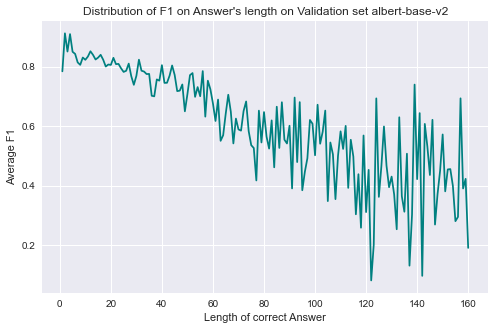

In [35]:
if duorc == True:
    ev.f1_graphic(ev.computes_f1_duorc(ground_truth, f1_raw),"Length of correct Answer",'Average F1', "Distribution of F1 on Answer's length on Validation set ", "Distribution_F1_Answers.png", model_checkpoint)
else:
    ev.f1_graphic(ev.computes_f1(ground_tr_dict, f1_raw),"Length of correct Answer",'Average F1', "Distribution of F1 on Answer's length on Validation set ", "Distribution_F1_Answers.png", model_checkpoint)

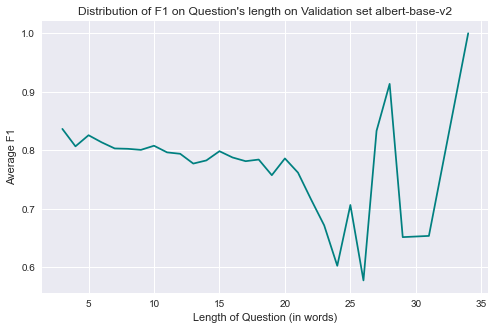

In [36]:
if duorc == True:
    ev.f1_graphic(ev.computes_f1_q_duorc(ground_tr_dict,f1_raw),"Length of Question (in words)",'Average F1', "Distribution of F1 on Question's length on Validation set ", "Distribution_F1_Question.png", model_checkpoint)
else:
    ev.f1_graphic(ev.computes_f1_q(ground_tr_dict,f1_raw),"Length of Question (in words)",'Average F1', "Distribution of F1 on Question's length on Validation set ", "Distribution_F1_Question.png", model_checkpoint)


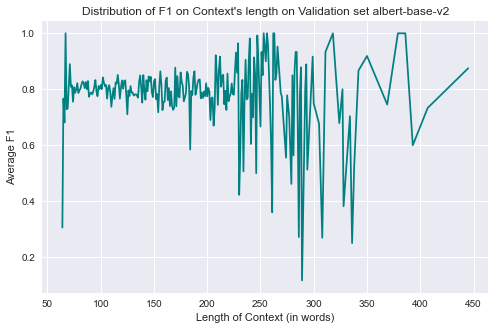

In [37]:
if duorc == True:
    ev.f1_graphic(ev.computes_f1_context_duorc(ground_tr_dict,f1_raw),"Length of Context (in words)",'Average F1', "Distribution of F1 on Context's length on Validation set ", "Distribution_F1_Context.png", model_checkpoint)
else:
    ev.f1_graphic(ev.computes_f1_context(ground_tr_dict,f1_raw),"Length of Context (in words)",'Average F1', "Distribution of F1 on Context's length on Validation set ", "Distribution_F1_Context.png", model_checkpoint)
